In [1]:
# Import necessary libraries and check GPU availability

import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5, ResNet50, VGG19, MobileNet
from tensorflow.keras.applications import InceptionV3, Xception  
from tensorflow.keras.layers import UpSampling2D, concatenate, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and will be used.")
    for gpu in gpus:
        print(f"GPU: {gpu}")
else:
    print("GPU is not available, using CPU instead.")

GPU is available and will be used.
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Dataset path (fold1-selected)
train_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold3_AUG/Train'
valid_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold3/Valid'
test_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold3/Test'

In [3]:
img_size = (224, 224)
batch_size = 16

In [4]:
# Data augmentation strategy
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Function to load data from a specific fold (the fold paths are already provided)
def load_data():
    # Load training, validation, and test data
    train_generator = train_datagen.flow_from_directory(
        train_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    validation_generator = train_datagen.flow_from_directory(
        valid_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

# Load the data
train_generator, validation_generator, test_generator = load_data()

Found 7532 images belonging to 6 classes.
Found 153 images belonging to 6 classes.
Found 64 images belonging to 6 classes.


In [6]:
# Check class indices to ensure they are correct
print(f"Class indices for the training data: {train_generator.class_indices}")

Class indices for the training data: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}


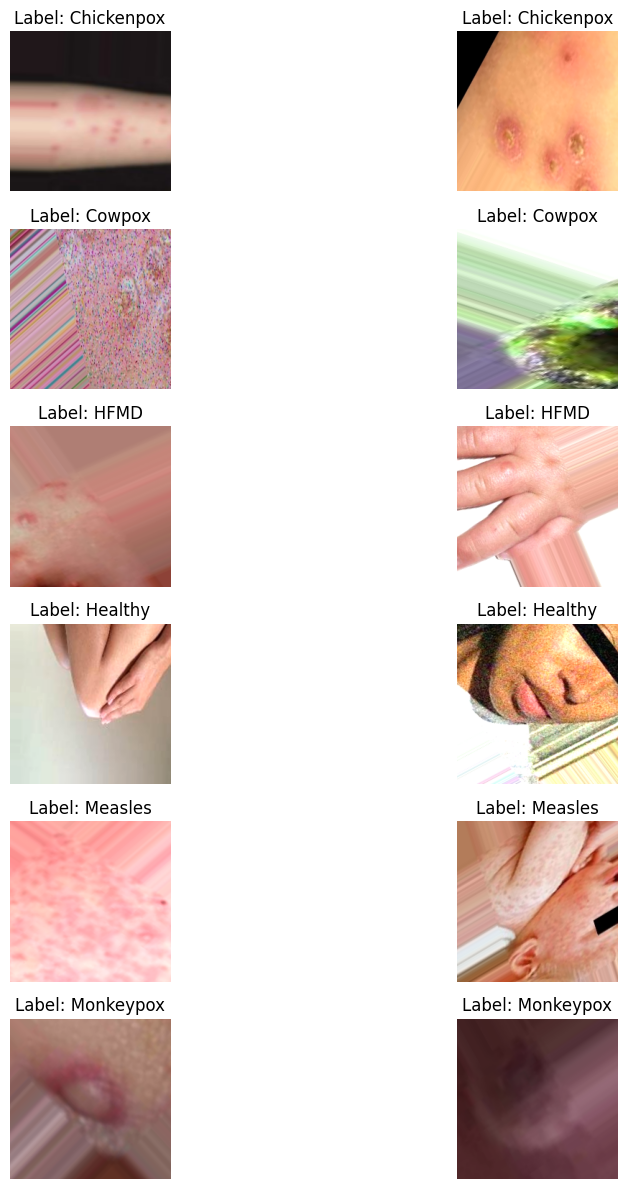

In [7]:
def plot_images_per_class(generator, num_images_per_class=2):
    # Invert the class_indices dictionary to get label -> class name mapping
    class_indices = {v: k for k, v in generator.class_indices.items()}
    num_classes = len(class_indices)
    
    # Initialize a dictionary to store images for each class
    images_per_class = {class_name: [] for class_name in class_indices.values()}

    # Loop until we have collected enough images for each class
    while any(len(images) < num_images_per_class for images in images_per_class.values()):
        images, labels = next(generator)
        
        # Process each image in the batch
        for img, label in zip(images, labels):
            class_label = np.argmax(label)  # Find the index of the one-hot encoded label
            class_name = class_indices[class_label]  # Get the class name from the class indices
            
            # Only add if we haven't collected enough images for this class
            if len(images_per_class[class_name]) < num_images_per_class:
                images_per_class[class_name].append(img)
    
    # Now that we have enough images, let's plot them
    plt.figure(figsize=(12, num_classes * 2))  # Adjust the figure size based on the number of classes
    img_idx = 1
    for class_name, images in images_per_class.items():
        for img in images:
            plt.subplot(num_classes, num_images_per_class, img_idx)
            img_idx += 1
            
            # Scale the image if necessary
            if img.max() > 1:
                img = img / 255.0
            
            plt.imshow(img)
            plt.title(f"Label: {class_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 2 images from each class from the training set
plot_images_per_class(train_generator, num_images_per_class=2)

In [8]:
# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights_resnet50 = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(labels), 
                                                  y=labels)
class_weights_dict_resnet50 = dict(enumerate(class_weights_resnet50))

# Build the ResNet50 model
def build_resnet50_model(input_shape=(224, 224, 3), num_classes=6):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the last 100 layers of ResNet50
    for layer in base_model.layers[-100:]:
        layer.trainable = True
    
    # Add custom layers for classification
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build the model
model_resnet50 = build_resnet50_model()

# Callbacks for early stopping, learning rate reduction, and model checkpoint
checkpoint_resnet50 = ModelCheckpoint("best_model_resnet50.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_resnet50 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler_resnet50 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model with class weights and callbacks
history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict_resnet50,
    callbacks=[checkpoint_resnet50, early_stopping_resnet50, lr_scheduler_resnet50]
)

# Evaluate the model on the test set
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(test_generator)
print(f"Test accuracy: {test_acc_resnet50}")

# Save the final model
model_resnet50.save('final_resnet50_model.keras')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728772137.493695     132 service.cc:145] XLA service 0x78c1080029b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728772137.493745     132 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/471 ━━━━━━━━━━━━━━━━━━━━ 8:05:10 62s/step - accuracy: 0.3750 - loss: 2.6818

I0000 00:00:1728772165.149057     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


471/471 ━━━━━━━━━━━━━━━━━━━━ 219s 333ms/step - accuracy: 0.3213 - loss: 2.1207 - val_accuracy: 0.1830 - val_loss: 4.9879 - learning_rate: 1.0000e-04
Epoch 2/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 109s 227ms/step - accuracy: 0.5191 - loss: 1.2822 - val_accuracy: 0.6078 - val_loss: 1.2911 - learning_rate: 1.0000e-04
Epoch 3/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.5942 - loss: 1.0297 - val_accuracy: 0.6209 - val_loss: 1.4168 - learning_rate: 1.0000e-04
Epoch 4/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 108s 227ms/step - accuracy: 0.6522 - loss: 0.8491 - val_accuracy: 0.6405 - val_loss: 1.0514 - learning_rate: 1.0000e-04
Epoch 5/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 104s 217ms/step - accuracy: 0.6835 - loss: 0.7883 - val_accuracy: 0.6405 - val_loss: 1.1818 - learning_rate: 1.0000e-04
Epoch 6/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 105s 219ms/step - accuracy: 0.7011 - loss: 0.7510 - val_accuracy: 0.5817 - val_loss: 1.2273 - learning_rate: 1.0000e-04
Epoch 7/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 107s 225ms/

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Classification Report for ResNet50 Model:
              precision    recall  f1-score   support

  Chickenpox       0.60      0.50      0.55         6
      Cowpox       0.80      1.00      0.89         4
        HFMD       0.71      0.94      0.81        16
     Healthy       0.83      0.91      0.87        11
     Measles       1.00      0.80      0.89         5
   Monkeypox       0.94      0.73      0.82        22

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.80        64
weighted avg       0.83      0.81      0.81        64

Precision: 0.8297050070028011
Recall: 0.8125
F1 Score: 0.8103468701294788


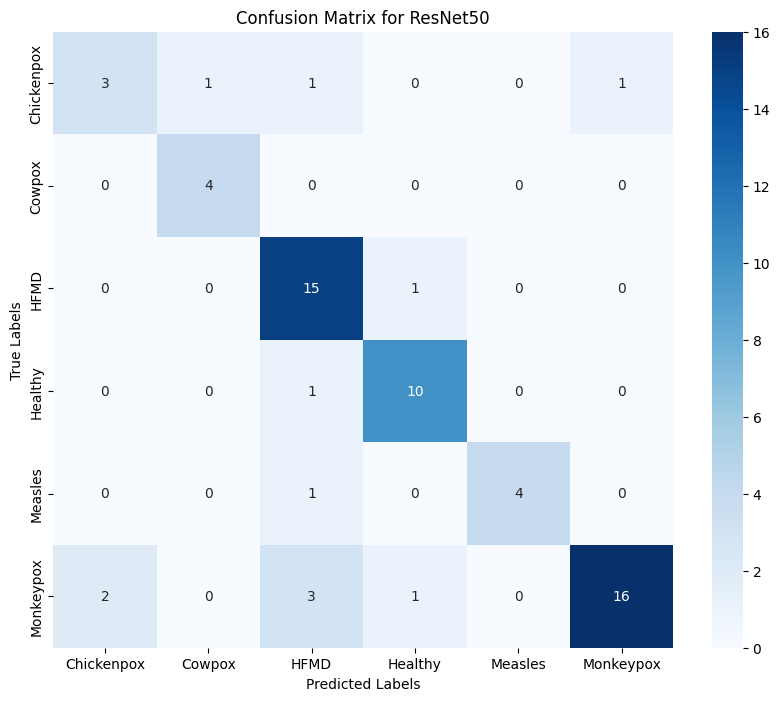

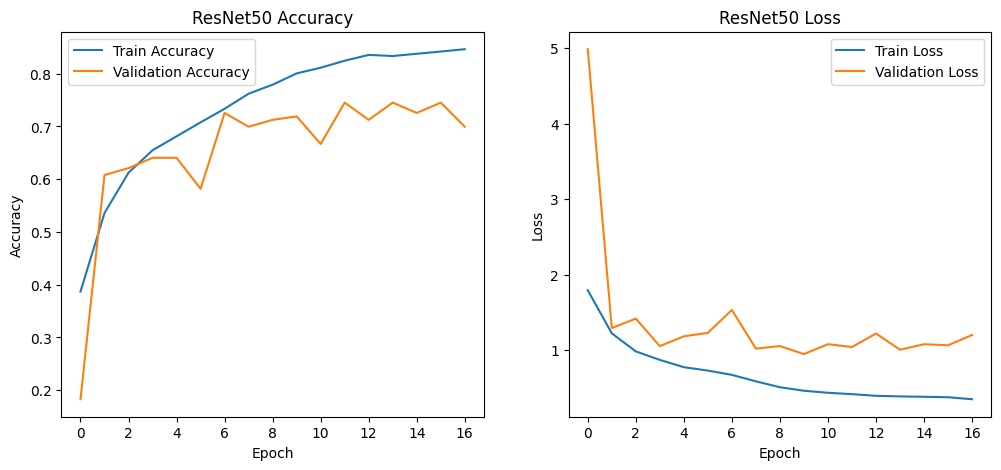

In [9]:
# Predictions on the test set
preds_resnet50 = model_resnet50.predict(test_generator)
y_preds_resnet50 = np.argmax(preds_resnet50, axis=1)
y_true_resnet50 = test_generator.classes

# Classification report
print("Classification Report for ResNet50 Model:")
print(classification_report(y_true_resnet50, y_preds_resnet50, target_names=test_generator.class_indices.keys()))

# Compute accuracy, precision, recall, and F1-score
accuracy_resnet50 = accuracy_score(y_true_resnet50, y_preds_resnet50)
precision_resnet50 = precision_score(y_true_resnet50, y_preds_resnet50, average='weighted', zero_division=0)
recall_resnet50 = recall_score(y_true_resnet50, y_preds_resnet50, average='weighted', zero_division=0)
f1_resnet50 = f1_score(y_true_resnet50, y_preds_resnet50, average='weighted', zero_division=0)

print(f"Precision: {precision_resnet50}")
print(f"Recall: {recall_resnet50}")
print(f"F1 Score: {f1_resnet50}")

# Confusion matrix
cm_resnet50 = confusion_matrix(y_true_resnet50, y_preds_resnet50)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet50, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Function to plot training history
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training history
plot_training_history(history_resnet50, model_name="ResNet50")